# Capstone Project: 
# <b>Venues indicating higher or lower housing prices in a neighbourhood</b>

## Introduction

This project will be aimed at home buyers, sellers and property professionals in London, UK, who want to know what are the indicators of cheaper or more expensive housing in a neighbourhood.

Currently, this audience may not be sure of the effect of certain venues on property prices in their neighbourhood. For example, they may not be sure whether a new pizza restaurant opening up nearby will be beneficial or detrimental to property prices in the area. The convenience of having a new restaurant nearby is good, but the additional noise from patrons may be a negative. The same with parks – the green space is good, but in some urban areas, parks may be seen as a security risk for nearby properties.

So we will aim to clarify what effect – positive or negative – different types of venues being present in a neighbourhood have on property rents and prices. 

We will identify the correlations between different types of venue being present in a neighbourhood, and average rental and sales prices in that area. Correlation is by no means causation, but this information should enable homeowners and potential buyers to better understand the effect of new venues opening up or closing down nearby, and how venues in the neighbourhood correlate with the rental or sales prices. 


## Data

### Sources 

In this section, we describe the data sources used, import them, and provide examples.

#### Property prices
The list of London district postcodes, and their associated average rental & sales prices will be scraped from <a href="https://www.findproperly.co.uk/">findproperly.co.uk</a>. For example, average weekly rent for a 1-bed flat in the BR1 district is £226. 

In [ ]:
# list of London postcode districts
postcodes = ['BR','CR','DA','E','EC','EN','HA','IG','KT','N','NW','RM','SE','SM','SW','TW','UB','W','WC','WD']

# create an empty dataframe, cycle through pages on FindProperly and append the property prices to it
df = pd.DataFrame()

for postcode in postcodes:
        df = df.append(pd.read_html('https://www.findproperly.co.uk/london/postcode/' + postcode)[0])

# save to CSV so we don't have to scrape again
df.to_csv('LondonHousePrice.csv',index=False)

In [212]:
# import the CSV and show the top rows

# read in the data
df = pd.read_csv('LondonHousePrice.csv')
df.head(2)

,Unnamed: 0_level_0,Unnamed: 1_level_0,Average weekly rent - beds:,Average weekly rent - beds:.1,Average weekly rent - beds:.2,Average weekly rent - beds:.3,Average for sale price - beds:,Average for sale price - beds:.1,Average for sale price - beds:.2,Average for sale price - beds:.3
0,District,Areas,1,2,3,4,1,2,3,4
1,BR1,NaN,£226,£312,£387,£570,£258k,£385k,£499k,£791k


#### Latitude and longitude of districts

The latitude and longitude of the postcodes will be pulled from a CSV file, downloaded from freemaptools.com. For example, the AB10 district has latitude 57.13514, longitude -2.11731.

In [175]:
# import latitude and longitude of all UK postcodes
pcs = pd.read_csv('postcode-outcodes.csv')
pcs.head(2)

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089


#### Venue data from Foursquare

The number of venues by category (Bakery, Library etc.) will be pulled from Foursquare API. London postcode districts vary significantly in size, so we will select 1 mile (~1,600 metres) as the radius for the search. With additional data on the approximate radius of each district, we could assign a different radius to each Foursquare search, but for this model we will keep it to one mile. We select 100 venues for each district, as this is the maximum currently returned by the API with our free account.

In [207]:
# credentials

CLIENT_ID = 'W1IQ2JTWNXQL3R14IGVEYENEDGEHMNS21AFCIY5IKDXZJWKI' # your Foursquare ID
CLIENT_SECRET = 'XZQLTLDQ0LSZJERNLHVXUTK0NN0ORYHAXDTV3SOWTIK5KO0V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1600 # setting radius to a mile

#### Python packages

Here we import the packages required for the notebook:

In [235]:
import pandas as pd # for data manipulation
import requests # for handling requests
from pandas.io.json import json_normalize # for tranforming JSON file into a pandas dataframe
import numpy as np # for additional data manipulation
from scipy.stats import pearsonr # for getting correlations and p-values
from sklearn.cluster import KMeans # for clustering
import folium # map rendering library
import matplotlib as mpl # for visualisation
import matplotlib.pyplot as plt # for visualisation
import seaborn as sns # for visualisation

## Method

### Data cleaning

First let's get the property price dataframe in the correct format, as it has been scraped with some erroneous headings. What it looks like now:

In [213]:
df.head(3)

,Unnamed: 0_level_0,Unnamed: 1_level_0,Average weekly rent - beds:,Average weekly rent - beds:.1,Average weekly rent - beds:.2,Average weekly rent - beds:.3,Average for sale price - beds:,Average for sale price - beds:.1,Average for sale price - beds:.2,Average for sale price - beds:.3
0,District,Areas,1,2,3,4,1,2,3,4
1,BR1,NaN,£226,£312,£387,£570,£258k,£385k,£499k,£791k
2,BR2,NaN,£213,£312,£419,£618,£285k,£376k,£548k,£649k


Rename the header columns:

In [214]:
df = df.rename(columns={'Unnamed: 0_level_0': 'District', 'Unnamed: 1_level_0': 'Areas', 'Average weekly rent - beds:':'1BedWeekRent','Average weekly rent - beds:.1':'2BedWeekRent','Average weekly rent - beds:.2':'3BedWeekRent','Average weekly rent - beds:.3':'4BedWeekRent','Average for sale price - beds:':'1BedSale','Average for sale price - beds:.1':'2BedSale','Average for sale price - beds:.2':'3BedSale','Average for sale price - beds:.3':'4BedSale'})
df.head(2)

,District,Areas,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale
0,District,Areas,1,2,3,4,1,2,3,4
1,BR1,NaN,£226,£312,£387,£570,£258k,£385k,£499k,£791k


Get rid of first row, and the Areas column as that data is incomplete:

In [215]:
df = df.loc[1:,:]
df.drop(['Areas'],axis=1,inplace=True)
df.head()

,District,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale
1,BR1,£226,£312,£387,£570,£258k,£385k,£499k,£791k
2,BR2,£213,£312,£419,£618,£285k,£376k,£548k,£649k
3,BR3,£232,£310,£396,£393,£280k,£378k,£499k,£698k
4,BR4,£231,£300,£288,£404,£109k,£325k,£574k,£626k
5,BR5,£112,£260,£320,£423,£154k,£330k,£455k,£721k


Convert the prices to numerical values, by removing £ signs, commas, converting 'k' to '000' and then changing the data type to numeric. By setting errors = 'ignore', we tell it to leave any columns that can't be converted to numeric, like the District column, as they are.

In [216]:

df.iloc[:,1:] = df.iloc[:,1:].replace('£', '',regex=True)
df.iloc[:,1:]  = df.iloc[:,1:].replace('k', '000',regex=True)
df.iloc[:,1:]  = df.iloc[:,1:].replace(',', '',regex=True)
df = df.apply(pd.to_numeric, errors='ignore')

#check data types
df.dtypes


District        object
1BedWeekRent     int64
2BedWeekRent     int64
3BedWeekRent     int64
4BedWeekRent     int64
1BedSale         int64
2BedSale         int64
3BedSale         int64
4BedSale         int64
dtype: object

Now we need to add in the latitude and longitude of these districts, by merging with the postcode data, and dropping the extra 'id' column that is not needed:

In [217]:
# add latitude and longitude onto the original dataframe
pcs.rename(columns={'postcode':'District'},inplace=True)
df = df.merge(pcs, on='District', how='left')
df.drop(['id'],axis=1,inplace=True)
df.head()

,District,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale,latitude,longitude
0,BR1,226,312,387,570,258000,385000,499000,791000,51.41107,0.02192
1,BR2,213,312,419,618,285000,376000,548000,649000,51.38858,0.02237
2,BR3,232,310,396,393,280000,378000,499000,698000,51.40297,-0.03020
3,BR4,231,300,288,404,109000,325000,574000,626000,51.37559,-0.00695
4,BR5,112,260,320,423,154000,330000,455000,721000,51.38983,0.10436


#### Request venue data from Foursquare

That's our price and location data ready. Now we make the request to Foursquare API, for the venue data in each district. First we create the function that will generate an API request URL for each of the postcode districts.

In [219]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The function is ready, so let's put it into practice:

In [220]:
london_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )



We save the results to CSV, to save our API quota if we want to retrieve the raw data in the future:

In [222]:
london_venues.to_csv('LondonFoursquareVenueData.csv',index=False)

Retrieve the results:

In [223]:
london_venues = pd.read_csv('LondonFoursquareVenueData.csv')
london_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BR1,51.41107,0.02192,Cinnamon Culture,51.414196,0.020883,Indian Restaurant
1,BR1,51.41107,0.02192,Barrel & Horn,51.405887,0.013701,Bar
2,BR1,51.41107,0.02192,Bromley Picturehouse,51.406740,0.012303,Indie Movie Theater
3,BR1,51.41107,0.02192,Nando's,51.406128,0.016046,Portuguese Restaurant
4,BR1,51.41107,0.02192,Marks & Spencer,51.404017,0.015718,Department Store


Check how many venues we got for each district:

In [240]:
venues_by_district = london_venues.groupby('District').count().iloc[:,0:1].rename(columns={'District Latitude':'Count of venues'})

We can see that at least a quarter of districts maxed out the limit at 100 venues, with the mean being approx. 57 venues per district. To improve this, we would need to break our districts down further and make multiple requests per district with slightly different geographical co-ordinates, and then deduplicate. However, in this case we will keep 100 venues per postcode.

In [243]:
venues_by_district.describe()

,Count of venues
count,278.000000
mean,57.147482
std,33.028210
min,1.000000
25%,28.250000
50%,53.000000
75%,100.000000
max,100.000000


#### Set up data for correlation analysis

As the venue data is categorical (the categories are text-based like 'Library', 'Park' etc., we need to one-hot encode these, which will turn each venue type into its own column with a 0 or 1 as appropriate to indicate the venue type.

Here we one-hot encode the london_venues data and then add that back onto the list of districts.

In [245]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['District'] = london_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

,District,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we want to know, for each district, how many of each venue type are present. We could sum the number of venues, but to get a better picture of the composition of each district, and normalise that for districts that have different numbers of venues in total, we take the mean. This results in a dataframe with a row for each district, and the proportion of venues that are of each type.

In [249]:
london_grouped = london_onehot.groupby('District').mean().reset_index()
london_grouped.head()

,District,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,BR1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BR2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BR3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BR4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BR5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To get all our data in the same place, we now merge this with the property prices:

In [250]:
full_df = df.merge(london_grouped, on='District',how='left')
full_df.head()

,District,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale,latitude,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,BR1,226,312,387,570,258000,385000,499000,791000,51.41107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BR2,213,312,419,618,285000,376000,548000,649000,51.38858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BR3,232,310,396,393,280000,378000,499000,698000,51.40297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BR4,231,300,288,404,109000,325000,574000,626000,51.37559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BR5,112,260,320,423,154000,330000,455000,721000,51.38983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Get correlations and associated p-values

Now all the data is in the same dataframe, we run a correlation analysis of every column versus every other column:

In [261]:
correl_df = full_df.corr()
correl_df.head()

,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale,latitude,longitude,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
1BedWeekRent,1.000000,0.873975,0.834197,0.426161,0.888009,0.820811,0.763152,0.811379,0.093134,-0.158831,...,-0.006752,0.482589,0.081930,0.060129,0.015559,0.115176,0.079966,0.470508,0.098053,0.119150
2BedWeekRent,0.873975,1.000000,0.884294,0.409583,0.872042,0.879880,0.845675,0.883165,0.015577,-0.155364,...,-0.024529,0.483098,0.109176,0.021109,-0.002721,0.120233,0.032315,0.447675,0.164578,0.164801
3BedWeekRent,0.834197,0.884294,1.000000,0.686912,0.819328,0.811886,0.766557,0.850932,0.023540,-0.117322,...,-0.019561,0.422262,0.038022,0.012401,-0.004796,0.083813,-0.000309,0.359245,0.152489,0.136247
4BedWeekRent,0.426161,0.409583,0.686912,1.000000,0.409211,0.396507,0.301386,0.444829,0.005927,-0.044166,...,-0.015066,0.145205,0.010503,0.037502,0.004630,0.026497,0.005932,0.133205,0.058305,0.065601
1BedSale,0.888009,0.872042,0.819328,0.409211,1.000000,0.884825,0.816338,0.833020,0.045279,-0.159816,...,-0.005330,0.524222,0.077287,0.036782,0.016677,0.115446,0.049931,0.511134,0.103928,0.128269


To cut it down to a more manageable size, we will keep the property price columns along the top, and each venue type as a separate row, and remove all other numbers:

In [262]:
# chop columns down to the prices only
correl_df = correl_df.iloc[10:, 0:8]
correl_df.head()

,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale
Accessories Store,-0.023403,-0.019067,-0.030808,-0.019962,-0.027410,-0.042202,-0.036088,-0.050408
Advertising Agency,-0.050415,-0.067448,-0.040784,-0.022006,-0.057956,-0.057174,-0.042937,-0.041187
Afghan Restaurant,-0.015160,-0.029145,-0.034318,-0.018925,-0.009685,-0.042385,-0.033411,-0.032173
African Restaurant,0.064035,0.033883,0.006246,-0.012923,0.057324,0.028880,0.000407,-0.020275
Airport,-0.041237,-0.031698,-0.032710,-0.016063,-0.028547,-0.040106,-0.031692,-0.036256


We now have the correlations of venue types with the different property prices. However, to make sure we are only looking at statistically significant correlations, we need to look at the p-values. So in the same way as before, we first get the p-values of the correlations of all columns against all other columns:

In [273]:
#calculate p values
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = pearsonr(df[r], df[c])[1]
    return pvalues

pvals = calculate_pvalues(full_df) 
pvals.head()

,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale,latitude,longitude,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
1BedWeekRent,0,1.75161e-88,2.62127e-73,1.07899e-13,4.05586e-95,4.36169e-69,2.89902e-54,2.55671e-66,0.121327,0.00797379,...,0.910764,1.26687e-17,0.17314,0.317821,0.796203,0.0550985,0.183708,1.0146e-16,0.102799,0.047172
2BedWeekRent,1.75161e-88,0,2.80189e-93,1.13691e-12,1.24375e-87,3.57527e-91,3.06817e-77,9.87044e-93,0.795968,0.00947192,...,0.683864,1.15845e-17,0.0691318,0.726034,0.963977,0.0451855,0.591601,4.16464e-15,0.00595085,0.00588246
3BedWeekRent,2.62127e-73,2.80189e-93,0,3.83014e-40,1.21788e-68,1.83181e-66,5.10431e-55,3.77982e-79,0.695964,0.0506909,...,0.745398,1.89952e-13,0.527833,0.83692,0.936551,0.163438,0.995906,6.82795e-10,0.010898,0.0230827
4BedWeekRent,1.07899e-13,1.13691e-12,3.83014e-40,0,1.19687e-12,6.66111e-12,3.02229e-07,6.4914e-15,0.921632,0.463293,...,0.802525,0.0153929,0.8616,0.533496,0.938737,0.660029,0.92157,0.0263603,0.332753,0.275695
1BedSale,4.05586e-95,1.24375e-87,1.21788e-68,1.19687e-12,0,1.54385e-93,9.38289e-68,6.37474e-73,0.452093,0.00758857,...,0.929497,5.0123e-21,0.198882,0.541384,0.781912,0.0545276,0.406947,6.61096e-20,0.0836841,0.0325266


And then cut that down to the same format as the correlation dataframe:

In [274]:
pvals = pvals.iloc[10:, 0:8]
pvals.head()

,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale
Accessories Store,0.697649,0.751619,0.609014,0.740362,0.649084,0.483436,0.549043,0.402469
Advertising Agency,0.402407,0.262377,0.498263,0.714884,0.335661,0.342233,0.475841,0.494026
Afghan Restaurant,0.801315,0.628482,0.568828,0.753402,0.872288,0.481538,0.57909,0.593232
African Restaurant,0.287348,0.573734,0.917428,0.830148,0.340969,0.631614,0.994617,0.736445
Airport,0.4935,0.598704,0.587076,0.789746,0.635558,0.505436,0.598776,0.547189


We set a threshold for significance at p<0.05, which is standard, and mark up whether each venue type has at least one significant correlation:

In [275]:
sig_pvals = pvals.copy()
sig_pvals['Significant'] = np.where(sig_pvals.min(axis=1)<0.05, 1,0)
sig_pvals = sig_pvals[sig_pvals['Significant']==1]
sig_pvals.head()

,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale,Significant
American Restaurant,0.0817474,0.0130912,0.0596631,0.332583,0.0136202,0.0467345,0.0964829,0.0634248,1
Animal Shelter,0.00884796,0.00809681,0.0118098,0.914349,0.0146603,0.0292089,0.0142391,0.351998,1
Argentinian Restaurant,0.000598621,0.000443255,0.00407403,0.34468,6.45926e-06,0.000254799,0.00216663,0.00191095,1
Art Gallery,1.98583e-10,9.11925e-10,7.25805e-12,1.88707e-06,1.83815e-10,1.1816e-06,1.40111e-05,2.32413e-10,1
Art Museum,9.53745e-18,1.12275e-23,3.1665e-30,5.35425e-14,4.23569e-21,1.14968e-22,1.47802e-19,5.97055e-23,1


Now we drop from the correlation dataframe, all the venues <b>without</b> any significant correlations:

In [276]:
sig_list = list(sig_pvals.index)
correl_df = correl_df.loc[sig_list]
correl_df.head()

,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale
American Restaurant,-0.104581,-0.148659,-0.113098,-0.058326,-0.147821,-0.119385,-0.099890,-0.111483
Animal Shelter,0.156744,0.158526,0.150821,0.006480,0.146252,0.130814,0.146875,0.056030
Argentinian Restaurant,0.204592,0.209294,0.171765,0.056885,0.266820,0.217700,0.183176,0.185369
Art Gallery,0.369658,0.356751,0.395858,0.281272,0.370297,0.286562,0.257278,0.368352
Art Museum,0.484201,0.553090,0.614248,0.430924,0.525056,0.542408,0.506933,0.545456


## Results

There's still a lot of information to look through. Looking at our data, we can see that all the different types of prices are generally affected in a similar way. We can verify this by looking at the original property prices data, and checking if there are any districts where the prices do not move in the same direction. Our original property prices data:

In [277]:
df.head()

,District,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale,latitude,longitude
0,BR1,226,312,387,570,258000,385000,499000,791000,51.41107,0.02192
1,BR2,213,312,419,618,285000,376000,548000,649000,51.38858,0.02237
2,BR3,232,310,396,393,280000,378000,499000,698000,51.40297,-0.03020
3,BR4,231,300,288,404,109000,325000,574000,626000,51.37559,-0.00695
4,BR5,112,260,320,423,154000,330000,455000,721000,51.38983,0.10436


There are 278 districts so a chart would get very messy! Let's check the correlations:

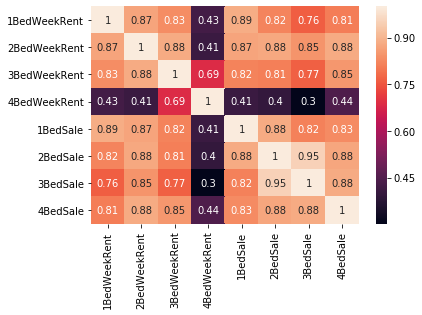

In [278]:
price_correl = df.corr()
price_correl = price_correl.iloc[0:8, 0:8]
sns.heatmap(price_correl, annot=True)

And also the p values:

In [281]:
pvals_price = calculate_pvalues(df) 
pvals_price = pvals_price.iloc[0:8, 0:8]
pvals_price

,1BedWeekRent,2BedWeekRent,3BedWeekRent,4BedWeekRent,1BedSale,2BedSale,3BedSale,4BedSale
1BedWeekRent,0,1.75161e-88,2.62127e-73,1.07899e-13,4.05586e-95,4.36169e-69,2.89902e-54,2.55671e-66
2BedWeekRent,1.75161e-88,0,2.80189e-93,1.13691e-12,1.24375e-87,3.57527e-91,3.06817e-77,9.87044e-93
3BedWeekRent,2.62127e-73,2.80189e-93,0,3.83014e-40,1.21788e-68,1.83181e-66,5.10431e-55,3.77982e-79
4BedWeekRent,1.07899e-13,1.13691e-12,3.83014e-40,0,1.19687e-12,6.66111e-12,3.02229e-07,6.4914e-15
1BedSale,4.05586e-95,1.24375e-87,1.21788e-68,1.19687e-12,0,1.54385e-93,9.38289e-68,6.37474e-73
2BedSale,4.36169e-69,3.57527e-91,1.83181e-66,6.66111e-12,1.54385e-93,0,2.45125e-145,3.17499e-89
3BedSale,2.89902e-54,3.06817e-77,5.10431e-55,3.02229e-07,9.38289e-68,2.45125e-145,0,6.50025e-93
4BedSale,2.55671e-66,9.87044e-93,3.77982e-79,6.4914e-15,6.37474e-73,3.17499e-89,6.50025e-93,0


So it appears all the property prices are correlated, but the average four-bed rent prices are much less strongly correlated with the other property prices. This may be due to fewer properties being 4-bed, and also a large share of 4-bed properties may be houses of multiple occupation (HMOs), where unrelated people then sub-rent separate rooms. We need to bear this unique case in mind, but to get some initial indication of which venues are correlated with high & low property prices let's just take an average across all price types. We are however, not able to weight this without knowing the number of properties that fall into each price type.

Venues that correlate with high property prices, excluding 4-bed rentals:

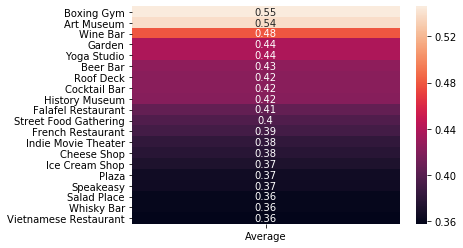

In [292]:
average_df = correl_df.copy()
average_df.drop('4BedWeekRent',axis=1,inplace=True)
average_df['Average'] = average_df.mean(axis=1)
average_df = average_df[['Average']].sort_values(by='Average',ascending=False)
sns.heatmap(average_df.head(20), annot=True)

Venues that correlate with low property prices:

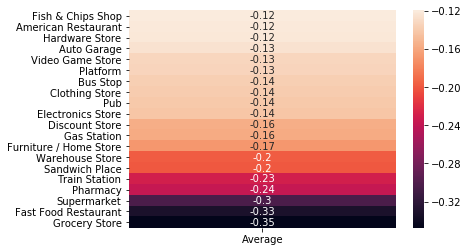

In [293]:
sns.heatmap(average_df.tail(20), annot=True)

And checking whether this is different for the 4-bed rentals, the positive correlations:

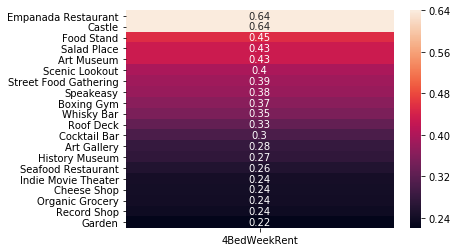

In [294]:
br4_df = correl_df[['4BedWeekRent']]
br4_df = br4_df[['4BedWeekRent']].sort_values(by='4BedWeekRent',ascending=False)
sns.heatmap(br4_df.head(20), annot=True)

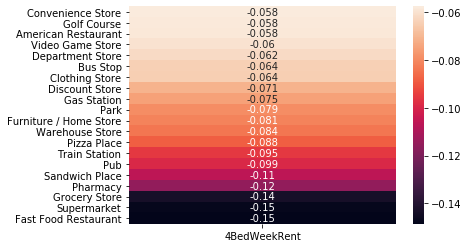

In [295]:
sns.heatmap(br4_df.tail(20), annot=True)

The venue lists are not particularly different, but the correlations are generally less strong, so we can conclude that a different factor - possibly the HMOs - are causing 4-bed rental prices to be less affected by venues.

## Discussion 
From the results, we can see that venues like art museums and wine bars are more common in districts with higher property prices. This is to be expected, but there are a few venues like boxing gyms, beer bars and falafel restaurants that are less obvious.
This may reassure people looking to rent or buy, that new venues of these types opening up are not likely to have a detrimental effect on property prices. However, if a fast food restaurant or supermarket plans to open up, this may have a negative effect, although the effect may be lower for 4-bed rentals. 
There may also be a positive side for prospective buyers or renters who do not mind living near the amenities on the ‘negative correlation’ list – they may be able to take advantage of lower prices in this area, if they have no personal objection to living near these amenities. However, buyers in particular should note that this may affect their ability and price at which they can sell the property on afterwards.


## Conclusion

We have used neighbourhood venue and property price data, to identify the venue types that correlate with higher or lower property prices, and how this changes specifically for 4-bed rentals. We have discussed how this affects homeowners, buyers and renters, and how they can use this information.
To make the analysis more robust, we would need to look at property prices in a neighbourhood before and after introduction of each venue type, which could be analysed in future work.
